# Credit Risk Modeling - Feature Engineering

**Dataset:** Lending Club Loan Data (2007-2018)

**Objective:** Transform raw data into ML-ready features using financial domain knowledge and prepare train/test splits.

---

## Table of Contents

1. [Setup & Data Loading](#1-setup--data-loading)
2. [Data Cleaning](#2-data-cleaning)
3. [Target Variable Creation](#3-target-variable-creation)
4. [Remove Data Leakage Features](#4-remove-data-leakage-features)
5. [Missing Values Strategy](#5-missing-values-strategy)
6. [Feature Engineering](#6-feature-engineering)
7. [Feature Selection](#7-feature-selection)
8. [Temporal Train/Test Split](#8-temporal-traintest-split)
9. [Data Export](#9-data-export)
10. [Summary](#10-summary)

---
## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime

# Visualization settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load dataset (últimos 500K registros - más recientes)
data_path = Path('../data/raw/lending_club.csv')

print("Loading most recent 500K loans...")

# Total rows en el dataset
total_rows = 2260668
n_rows_to_load = 500000
skip_rows = total_rows - n_rows_to_load

print(f"Skipping first {skip_rows:,} rows")
print(f"Loading last {n_rows_to_load:,} rows (most recent loans)...\n")

# Load data
df = pd.read_csv(
    data_path, 
    skiprows=range(1, skip_rows + 1),
    engine='c'
)

print("✓ Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading most recent 500K loans...
Skipping first 1,760,668 rows
Loading last 500,000 rows (most recent loans)...

✓ Data loaded successfully!
Dataset shape: (500033, 151)
Memory usage: 1412.74 MB


In [3]:
# Parse dates
if 'issue_d' in df.columns:
    df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
    print(f"Date range: {df['issue_d'].min()} to {df['issue_d'].max()}")

if 'earliest_cr_line' in df.columns:
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')

Date range: 2012-01-01 00:00:00 to 2017-12-01 00:00:00


---
## 2. Data Cleaning

In [4]:
# Identify columns with >80% missing values (useless for modeling)
missing_threshold = 0.8
missing_pct = df.isnull().sum() / len(df)
cols_to_drop_missing = missing_pct[missing_pct > missing_threshold].index.tolist()

print(f"Columns with >{missing_threshold*100}% missing: {len(cols_to_drop_missing)}")
print("\nColumns to drop (high missing):")
print(cols_to_drop_missing[:20])  # Show first 20

Columns with >80.0% missing: 39

Columns to drop (high missing):
['member_id', 'desc', 'mths_since_last_record', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type']


In [5]:
# Additional columns to drop (not useful for modeling)
drop_cols_useless = [
    'id',                # Unique identifier
    'member_id',         # Unique identifier
    'url',               # URL to loan page
    'desc',              # Free text description
    'title',             # Loan title
    'zip_code',          # Too granular, use state instead
    'emp_title',         # Too many categories, use emp_length
]

# Filter only existing columns
drop_cols_useless = [col for col in drop_cols_useless if col in df.columns]

print(f"\nAdditional useless columns: {len(drop_cols_useless)}")
print(drop_cols_useless)


Additional useless columns: 7
['id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'emp_title']


In [6]:
# Combine all columns to drop
all_cols_to_drop = list(set(cols_to_drop_missing + drop_cols_useless))

print(f"\nTotal columns to drop: {len(all_cols_to_drop)}")
print(f"Columns before cleaning: {len(df.columns)}")

# Drop columns
df_clean = df.drop(columns=all_cols_to_drop, errors='ignore')

print(f"Columns after cleaning: {len(df_clean.columns)}")
print(f"Reduction: {len(all_cols_to_drop)} columns")


Total columns to drop: 44
Columns before cleaning: 151
Columns after cleaning: 107
Reduction: 44 columns


---
## 3. Target Variable Creation

In [7]:
# Define default and paid statuses
default_statuses = [
    'Charged Off',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]

paid_statuses = [
    'Fully Paid',
    'Does not meet the credit policy. Status:Fully Paid'
]

# Statuses to exclude (outcome unknown)
exclude_statuses = [
    'Current',
    'Late (31-120 days)',
    'Late (16-30 days)',
    'In Grace Period',
    'Issued'
]

print("Loan Status Distribution (before filtering):\n")
print(df_clean['loan_status'].value_counts())

Loan Status Distribution (before filtering):

loan_status
Fully Paid            266023
Current               161286
Charged Off            64992
Late (31-120 days)      4969
In Grace Period         1774
Late (16-30 days)        968
Default                   13
Name: count, dtype: int64


In [8]:
# Create binary target
df_clean['target'] = df_clean['loan_status'].apply(
    lambda x: 1 if x in default_statuses else (0 if x in paid_statuses else np.nan)
)

# Filter out loans with unknown outcome
df_clean = df_clean[df_clean['target'].notna()].copy()

print("\nTarget Variable Distribution (after filtering):\n")
print(df_clean['target'].value_counts())
print(f"\nDefault Rate: {df_clean['target'].mean() * 100:.2f}%")
print(f"Final dataset size: {len(df_clean):,} loans")


Target Variable Distribution (after filtering):

target
0.000    266023
1.000     65005
Name: count, dtype: int64

Default Rate: 19.64%
Final dataset size: 331,028 loans


---
## 4. Remove Data Leakage Features

**Critical:** Remove features that are only known AFTER the loan outcome.

In [9]:
# Features that cause data leakage (post-loan information)
leakage_features = [
    # Payment history (only known after loan is issued)
    'funded_amnt',
    'funded_amnt_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'out_prncp',
    'out_prncp_inv',
    'total_bal_ex_mort',
    'total_bc_limit',
    'total_il_high_credit_limit',
    # Target-related
    'loan_status'  # Already encoded in target
]

# Filter only existing columns
leakage_features = [col for col in leakage_features if col in df_clean.columns]

print(f"Data leakage features to remove: {len(leakage_features)}")
print(leakage_features[:15])  # Show first 15

# Remove leakage features
df_clean = df_clean.drop(columns=leakage_features, errors='ignore')

print(f"\nColumns after removing leakage: {len(df_clean.columns)}")

Data leakage features to remove: 19
['funded_amnt', 'funded_amnt_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'out_prncp', 'out_prncp_inv']

Columns after removing leakage: 89


---
## 5. Missing Values Strategy

Handle missing values with **financial domain logic**, not blind imputation.

In [10]:
# Analyze remaining missing values
missing_summary = pd.DataFrame({
    'column': df_clean.columns,
    'missing_count': df_clean.isnull().sum(),
    'missing_pct': (df_clean.isnull().sum() / len(df_clean)) * 100
}).sort_values('missing_pct', ascending=False)

missing_cols = missing_summary[missing_summary['missing_count'] > 0]

print(f"Columns with missing values: {len(missing_cols)}\n")
print("Top 20 with highest missing %:\n")
print(missing_cols.head(20))

Columns with missing values: 52

Top 20 with highest missing %:

                                                        column  missing_count  \
mths_since_recent_bc_dlq              mths_since_recent_bc_dlq         258976   
mths_since_last_major_derog        mths_since_last_major_derog         256308   
mths_since_recent_revol_delinq  mths_since_recent_revol_delinq         226368   
il_util                                                il_util         198491   
mths_since_rcnt_il                          mths_since_rcnt_il         182545   
all_util                                              all_util         178726   
inq_last_12m                                      inq_last_12m         178705   
total_cu_tl                                        total_cu_tl         178705   
inq_fi                                                  inq_fi         178705   
max_bal_bc                                          max_bal_bc         178705   
open_rv_12m                                 

In [11]:
# Missing value imputation strategy (financial logic)

# 1. Employment length: Missing = 0 (unemployed/unknown, conservative)
if 'emp_length' in df_clean.columns:
    # Extract numeric years from 'X years' format
    df_clean['emp_length_years'] = df_clean['emp_length'].str.extract('(\d+)').astype(float)
    df_clean['emp_length_years'] = df_clean['emp_length_years'].fillna(0)
    print("✓ emp_length processed")

# 2. Months since last delinquency: Missing = 999 (never delinquent, good sign)
if 'mths_since_last_delinq' in df_clean.columns:
    df_clean['mths_since_last_delinq'] = df_clean['mths_since_last_delinq'].fillna(999)
    print("✓ mths_since_last_delinq imputed (999 = never)")

# 3. Months since last record: Missing = 999 (no public records)
if 'mths_since_last_record' in df_clean.columns:
    df_clean['mths_since_last_record'] = df_clean['mths_since_last_record'].fillna(999)
    print("✓ mths_since_last_record imputed (999 = never)")

# 4. Revolving utilization: Missing = median
if 'revol_util' in df_clean.columns:
    median_revol_util = df_clean['revol_util'].median()
    df_clean['revol_util'] = df_clean['revol_util'].fillna(median_revol_util)
    print(f"✓ revol_util imputed (median = {median_revol_util:.2f})")

# 5. DTI: Missing = median by grade (borrowers with similar risk)
if 'dti' in df_clean.columns and 'grade' in df_clean.columns:
    df_clean['dti'] = df_clean.groupby('grade')['dti'].transform(
        lambda x: x.fillna(x.median())
    )
    print("✓ dti imputed (group median by grade)")

# 6. Annual income: Missing = median
if 'annual_inc' in df_clean.columns:
    median_income = df_clean['annual_inc'].median()
    df_clean['annual_inc'] = df_clean['annual_inc'].fillna(median_income)
    print(f"✓ annual_inc imputed (median = ${median_income:,.0f})")

print("\n✓ Missing value imputation complete!")

✓ emp_length processed
✓ mths_since_last_delinq imputed (999 = never)
✓ revol_util imputed (median = 54.30)
✓ dti imputed (group median by grade)
✓ annual_inc imputed (median = $65,000)

✓ Missing value imputation complete!


---
## 6. Feature Engineering

Create new features using **financial domain knowledge**.

In [12]:
print("Creating domain-driven features...\n")

# 1. Credit Utilization Rate
if 'revol_bal' in df_clean.columns and 'revol_util' in df_clean.columns:
    # Safer calculation avoiding division by zero
    df_clean['credit_util_rate'] = df_clean['revol_util'] / 100  # Already a percentage
    print("✓ credit_util_rate created")

# 2. Payment-to-Income Ratio
if 'installment' in df_clean.columns and 'annual_inc' in df_clean.columns:
    df_clean['payment_to_income'] = (df_clean['installment'] * 12) / (df_clean['annual_inc'] + 1)
    print("✓ payment_to_income created")

# 3. Loan-to-Income Ratio
if 'loan_amnt' in df_clean.columns and 'annual_inc' in df_clean.columns:
    df_clean['loan_to_income'] = df_clean['loan_amnt'] / (df_clean['annual_inc'] + 1)
    print("✓ loan_to_income created")

# 4. Credit History Length (years)
if 'earliest_cr_line' in df_clean.columns and 'issue_d' in df_clean.columns:
    df_clean['credit_history_years'] = (
        (df_clean['issue_d'] - df_clean['earliest_cr_line']).dt.days / 365.25
    )
    # Handle negative or null values
    df_clean['credit_history_years'] = df_clean['credit_history_years'].clip(lower=0)
    print("✓ credit_history_years created")

# 5. Total Debt Burden
if 'dti' in df_clean.columns and 'payment_to_income' in df_clean.columns:
    df_clean['total_debt_burden'] = df_clean['dti'] + (df_clean['payment_to_income'] * 100)
    print("✓ total_debt_burden created")

# 6. Employment Stability Flag
if 'emp_length_years' in df_clean.columns:
    df_clean['stable_employment'] = (df_clean['emp_length_years'] >= 5).astype(int)
    print("✓ stable_employment created")

# 7. Recent Credit Activity (high inquiries = risky)
if 'inq_last_6mths' in df_clean.columns:
    df_clean['high_inquiries'] = (df_clean['inq_last_6mths'] > 2).astype(int)
    print("✓ high_inquiries created")

# 8. Recent Delinquencies Flag
if 'delinq_2yrs' in df_clean.columns:
    df_clean['has_delinquencies'] = (df_clean['delinq_2yrs'] > 0).astype(int)
    print("✓ has_delinquencies created")

# 9. High-Risk Loan Purpose
if 'purpose' in df_clean.columns:
    high_risk_purposes = ['small_business', 'renewable_energy', 'educational']
    df_clean['high_risk_purpose'] = df_clean['purpose'].isin(high_risk_purposes).astype(int)
    print("✓ high_risk_purpose created")

# 10. Interest Rate × DTI (interaction feature)
if 'int_rate' in df_clean.columns and 'dti' in df_clean.columns:
    df_clean['rate_dti_interaction'] = df_clean['int_rate'] * df_clean['dti']
    print("✓ rate_dti_interaction created")

print("\n✓ Feature engineering complete!")
print(f"Total features now: {len(df_clean.columns)}")

Creating domain-driven features...

✓ credit_util_rate created
✓ payment_to_income created
✓ loan_to_income created
✓ credit_history_years created
✓ total_debt_burden created
✓ stable_employment created
✓ high_inquiries created
✓ has_delinquencies created
✓ high_risk_purpose created
✓ rate_dti_interaction created

✓ Feature engineering complete!
Total features now: 100


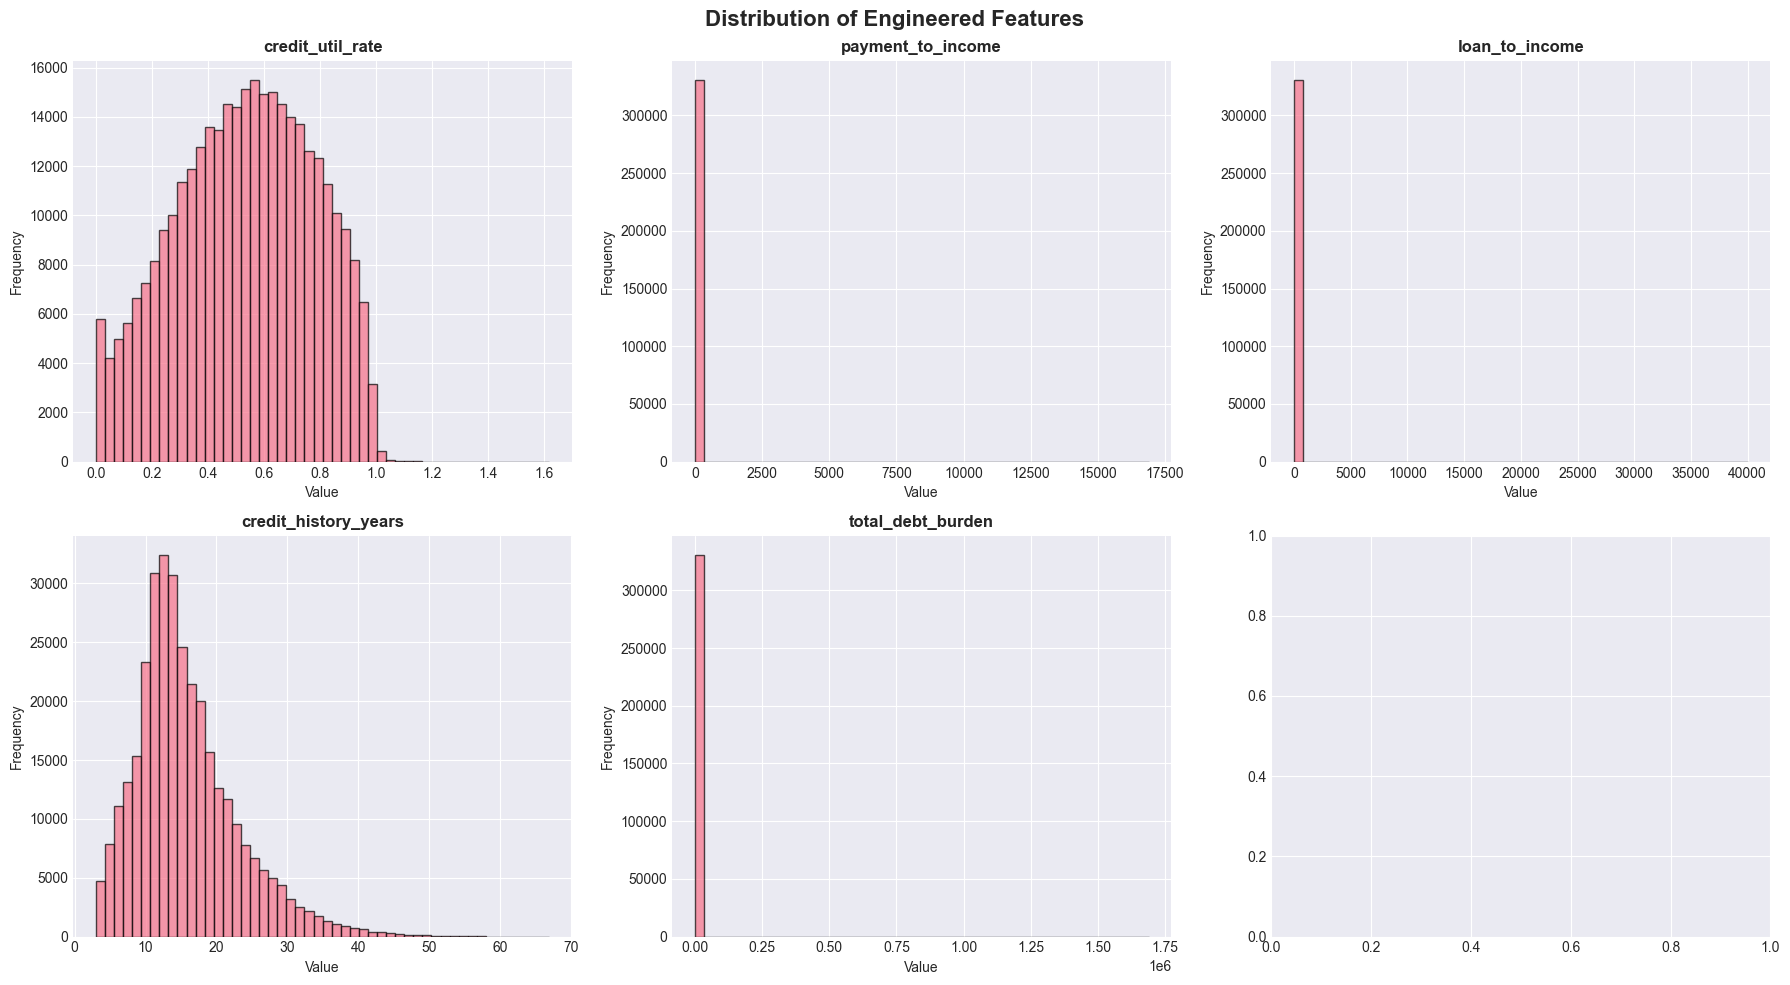

In [13]:
# Visualize new features
new_features = [
    'credit_util_rate', 'payment_to_income', 'loan_to_income',
    'credit_history_years', 'total_debt_burden'
]

# Filter existing features
new_features = [f for f in new_features if f in df_clean.columns]

if new_features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, feature in enumerate(new_features[:6]):
        axes[idx].hist(df_clean[feature].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')

    plt.suptitle('Distribution of Engineered Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## 7. Feature Selection

Select the most relevant features for modeling.

In [14]:
# Separate numerical and categorical features
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target and date columns from feature lists
numerical_cols = [col for col in numerical_cols if col not in ['target']]
categorical_cols = [col for col in categorical_cols if col not in ['issue_d', 'earliest_cr_line']]

print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

print("\nNumerical features:")
print(numerical_cols[:20])  # Show first 20

print("\nCategorical features:")
print(categorical_cols)

Numerical features: 83
Categorical features: 14

Numerical features:
['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code']

Categorical features:
['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


Top 20 Features by Correlation with Target:

int_rate               0.229
rate_dti_interaction   0.159
acc_open_past_24mths   0.093
num_tl_op_past_12m     0.085
all_util               0.082
open_rv_24m            0.079
dti                    0.077
num_actv_rev_tl        0.068
loan_amnt              0.067
num_rev_tl_bal_gt_0    0.064
open_rv_12m            0.064
installment            0.062
inq_last_6mths         0.054
open_acc_6m            0.053
inq_last_12m           0.053
bc_util                0.052
percent_bc_gt_75       0.051
revol_util             0.047
credit_util_rate       0.047
il_util                0.041
Name: target, dtype: float64


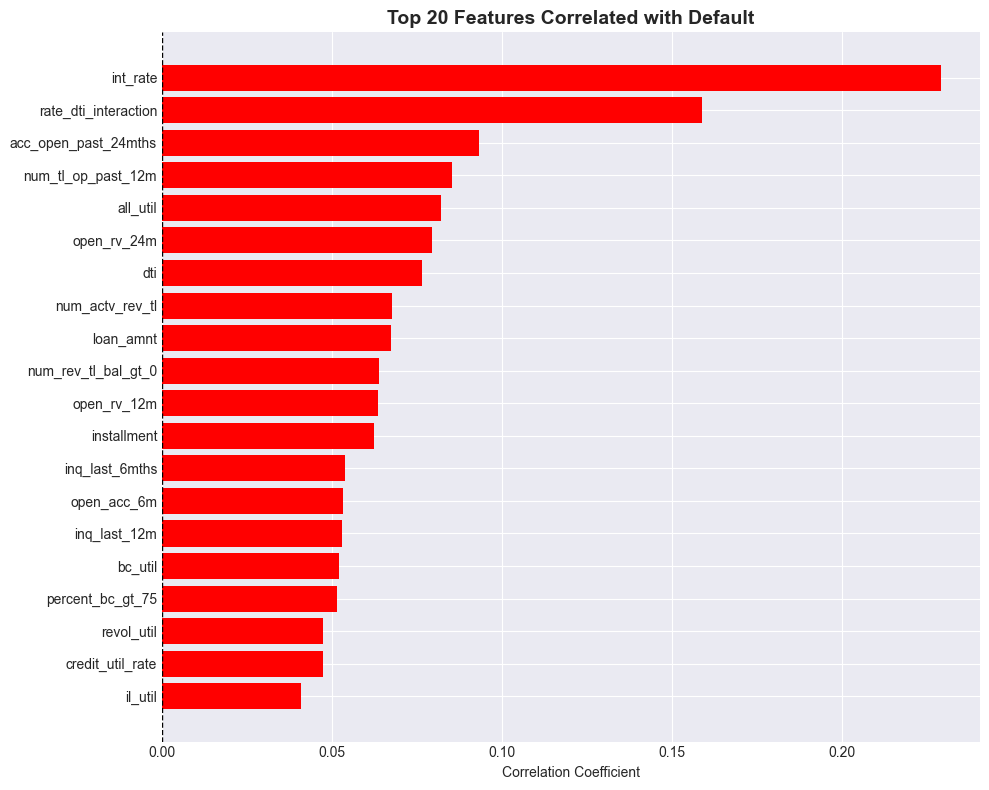

In [15]:
# Calculate correlation with target for numerical features
correlations = df_clean[numerical_cols + ['target']].corr()['target'].drop('target').sort_values(ascending=False)

print("Top 20 Features by Correlation with Target:\n")
print(correlations.head(20))

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
top_20_corr = correlations.head(20)
colors = ['green' if x < 0 else 'red' for x in top_20_corr]
ax.barh(range(len(top_20_corr)), top_20_corr.values, color=colors)
ax.set_yticks(range(len(top_20_corr)))
ax.set_yticklabels(top_20_corr.index)
ax.set_xlabel('Correlation Coefficient')
ax.set_title('Top 20 Features Correlated with Default', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

df_encoded = df_clean.copy()
label_encoders = {}

for col in categorical_cols:
    if col in df_encoded.columns:
        le = LabelEncoder()
        # Handle NaN values
        df_encoded[col] = df_encoded[col].fillna('missing')
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

print(f"✓ Encoded {len(label_encoders)} categorical features")
print(f"Features: {list(label_encoders.keys())}")

✓ Encoded 14 categorical features
Features: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


---
## 8. Temporal Train/Test Split

**Critical:** Split by time, not randomly, to simulate production.

In [17]:
# Define temporal split date
# Use 80% for training (earlier dates), 20% for testing (recent dates)
split_date = df_encoded['issue_d'].quantile(0.8)

print(f"Split date: {split_date}")
print(f"Train: loans before {split_date.date()}")
print(f"Test: loans on or after {split_date.date()}")

# Create train/test sets
train_df = df_encoded[df_encoded['issue_d'] < split_date].copy()
test_df = df_encoded[df_encoded['issue_d'] >= split_date].copy()

print(f"\nTrain set size: {len(train_df):,} ({len(train_df)/len(df_encoded)*100:.1f}%)")
print(f"Test set size: {len(test_df):,} ({len(test_df)/len(df_encoded)*100:.1f}%)")

print(f"\nTrain default rate: {train_df['target'].mean()*100:.2f}%")
print(f"Test default rate: {test_df['target'].mean()*100:.2f}%")

Split date: 2016-11-01 00:00:00
Train: loans before 2016-11-01
Test: loans on or after 2016-11-01

Train set size: 258,553 (78.1%)
Test set size: 72,475 (21.9%)

Train default rate: 18.65%
Test default rate: 23.14%


In [18]:
# Prepare features and target
# Drop non-feature columns
cols_to_drop = ['target', 'issue_d', 'earliest_cr_line']
cols_to_drop = [col for col in cols_to_drop if col in train_df.columns]

X_train = train_df.drop(columns=cols_to_drop)
y_train = train_df['target']

X_test = test_df.drop(columns=cols_to_drop)
y_test = test_df['target']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nFeatures: {len(X_train.columns)}")

X_train shape: (258553, 97)
X_test shape: (72475, 97)

Features: 97


In [19]:
# Handle remaining missing values (if any)
print("Checking for remaining missing values...\n")

missing_train = X_train.isnull().sum()
missing_test = X_test.isnull().sum()

if missing_train.sum() > 0:
    print("Train set - Columns with missing values:")
    print(missing_train[missing_train > 0])
    
    # Fill remaining with median
    for col in X_train.columns:
        if X_train[col].isnull().sum() > 0:
            if X_train[col].dtype in [np.float64, np.int64]:
                fill_value = X_train[col].median()
                X_train[col] = X_train[col].fillna(fill_value)
                X_test[col] = X_test[col].fillna(fill_value)

print("\n✓ All missing values handled!")
print(f"Train missing: {X_train.isnull().sum().sum()}")
print(f"Test missing: {X_test.isnull().sum().sum()}")

Checking for remaining missing values...

Train set - Columns with missing values:
mths_since_last_major_derog       204341
tot_coll_amt                       27741
tot_cur_bal                        27741
open_acc_6m                       178705
open_act_il                       178705
open_il_12m                       178705
open_il_24m                       178705
mths_since_rcnt_il                180529
total_bal_il                      178705
il_util                           188818
open_rv_12m                       178705
open_rv_24m                       178705
max_bal_bc                        178705
all_util                          178711
total_rev_hi_lim                   27741
inq_fi                            178705
total_cu_tl                       178705
inq_last_12m                      178705
acc_open_past_24mths                7495
avg_cur_bal                        27747
bc_open_to_buy                      9891
bc_util                            10008
mo_sin_old_il_a

---
## 9. Data Export

Save processed datasets for model training.

In [20]:
# Create processed data directory
processed_dir = Path('../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

# Save train/test sets
print("Saving processed datasets...\n")

train_df.to_csv(processed_dir / 'train_data.csv', index=False)
print(f"✓ Saved: {processed_dir / 'train_data.csv'}")

test_df.to_csv(processed_dir / 'test_data.csv', index=False)
print(f"✓ Saved: {processed_dir / 'test_data.csv'}")

# Save feature names
with open(processed_dir / 'feature_names.txt', 'w') as f:
    f.write('\n'.join(X_train.columns))
print(f"✓ Saved: {processed_dir / 'feature_names.txt'}")

# Save label encoders (for categorical features)
import joblib
joblib.dump(label_encoders, processed_dir / 'label_encoders.pkl')
print(f"✓ Saved: {processed_dir / 'label_encoders.pkl'}")

print("\n✓ Data export complete!")

Saving processed datasets...

✓ Saved: ..\data\processed\train_data.csv
✓ Saved: ..\data\processed\test_data.csv
✓ Saved: ..\data\processed\feature_names.txt
✓ Saved: ..\data\processed\label_encoders.pkl

✓ Data export complete!


---
## 10. Summary

In [21]:
print("="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

print("\n1. DATA CLEANING:")
print(f"   - Original columns: {len(df.columns)}")
print(f"   - After cleaning: {len(df_clean.columns)}")
print(f"   - Removed: {len(df.columns) - len(df_clean.columns)} columns")

print("\n2. TARGET VARIABLE:")
print(f"   - Default rate: {df_clean['target'].mean()*100:.2f}%")
print(f"   - Total samples: {len(df_clean):,}")
print(f"   - Defaults: {df_clean['target'].sum():,}")
print(f"   - Non-defaults: {(df_clean['target']==0).sum():,}")

print("\n3. FEATURE ENGINEERING:")
engineered_features = [
    'credit_util_rate', 'payment_to_income', 'loan_to_income',
    'credit_history_years', 'total_debt_burden', 'stable_employment',
    'high_inquiries', 'has_delinquencies', 'high_risk_purpose',
    'rate_dti_interaction'
]
existing_eng_features = [f for f in engineered_features if f in df_clean.columns]
print(f"   - New features created: {len(existing_eng_features)}")
print(f"   - Features: {', '.join(existing_eng_features)}")

print("\n4. DATA LEAKAGE:")
print(f"   - Removed {len(leakage_features)} features with data leakage")

print("\n5. MISSING VALUES:")
print(f"   - Imputed with financial domain logic")
print(f"   - Remaining missing: {X_train.isnull().sum().sum()} (train), {X_test.isnull().sum().sum()} (test)")

print("\n6. TRAIN/TEST SPLIT:")
print(f"   - Split method: Temporal (by issue_d)")
print(f"   - Split date: {split_date.date()}")
print(f"   - Train size: {len(X_train):,} ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"   - Test size: {len(X_test):,} ({len(X_test)/len(df_clean)*100:.1f}%)")

print("\n7. FINAL FEATURES:")
print(f"   - Total features: {len(X_train.columns)}")
print(f"   - Numerical: {len([c for c in X_train.columns if X_train[c].dtype in [np.float64, np.int64]])}")
print(f"   - Categorical (encoded): {len([c for c in categorical_cols if c in X_train.columns])}")

print("\n8. TOP PREDICTIVE FEATURES:")
print(correlations.head(10))

print("\n" + "="*70)
print("NEXT STEPS - MODEL TRAINING")
print("="*70)

print("""
1. Load processed data from data/processed/
2. Train baseline model (Logistic Regression)
3. Train advanced models (Random Forest, XGBoost)
4. Handle class imbalance (SMOTE, class weights)
5. Hyperparameter tuning
6. Model evaluation with business metrics
7. Feature importance analysis
8. Model interpretation (SHAP values)
""")

print("="*70)

FEATURE ENGINEERING SUMMARY

1. DATA CLEANING:
   - Original columns: 151
   - After cleaning: 100
   - Removed: 51 columns

2. TARGET VARIABLE:
   - Default rate: 19.64%
   - Total samples: 331,028
   - Defaults: 65,005.0
   - Non-defaults: 266,023

3. FEATURE ENGINEERING:
   - New features created: 10
   - Features: credit_util_rate, payment_to_income, loan_to_income, credit_history_years, total_debt_burden, stable_employment, high_inquiries, has_delinquencies, high_risk_purpose, rate_dti_interaction

4. DATA LEAKAGE:
   - Removed 19 features with data leakage

5. MISSING VALUES:
   - Imputed with financial domain logic
   - Remaining missing: 0 (train), 0 (test)

6. TRAIN/TEST SPLIT:
   - Split method: Temporal (by issue_d)
   - Split date: 2016-11-01
   - Train size: 258,553 (78.1%)
   - Test size: 72,475 (21.9%)

7. FINAL FEATURES:
   - Total features: 97
   - Numerical: 79
   - Categorical (encoded): 14

8. TOP PREDICTIVE FEATURES:
int_rate               0.229
rate_dti_interactio